## Import libraries

In [2]:
#import sys
#cpath = '/home/shihao/ProjectDiego/tutorials/pyTorch/dl-pytorch'
#sys.path.append(cpath)

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F # Layers without parameters 
from torch.utils.data import Dataset, DataLoader
from plot_helpers import imshow
from PIL import Image

## Create NN

In [4]:
class Net(nn.Module):
    def __init__(self, num_channels):
        super(Net, self).__init__()

        self.num_channels = num_channels

        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)

        self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)

    def forward(self, x):
        # init shape: 3x64x64
        x = self.conv1(x)               # num_channelsx64x64
        x = F.relu(F.max_pool2d(x, 2))  # num_channelsx32x32
        x = self.conv2(x)               # num_channels*2x32x32
        x = F.relu(F.max_pool2d(x, 2))  # num_channels*2x16x16
        x = self.conv3(x)               # num_channels*4x16x16
        x = F.relu(F.max_pool2d(x, 2))  # num_channels*4x8x8

        # Flatten
        x = x.view(-1, self.num_channels*4*8*8)

        # FC 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        # Log_softmax
        x = F.log_softmax(x, dim=1)

        return x


In [5]:
class SIGNSDataset(Dataset):
    def __init__(self, base_dir, split="train", transform=None) -> None:
        path = os.path.join(base_dir, "{}_signs".format(split))
        files = os.listdir(path)

        self.filenames = [os.path.join(path,f) for f in files if f.endswith(".jpg")]

        self.targets = [int(f[0]) for f in files]
        self.transform = transform

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx])
        if self.transform:
            image = self.transform(image)

        return image, self.targets[idx]

In [6]:
signs = SIGNSDataset('/home/shihao/ProjectDiego/tutorials/pyTorch/dl-pytorch/datasets/64x64_SIGNS', split="train")

In [7]:
len(signs)

864

1


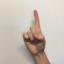

In [8]:
print(signs[0][1])
signs[0][0]

## Training

In [9]:
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.utils import make_grid

In [10]:
trainset = SIGNSDataset('/home/shihao/ProjectDiego/tutorials/pyTorch/dl-pytorch/datasets/64x64_SIGNS', split="train", transform = transforms.ToTensor())

In [11]:
# Dataloader gives batches of images. IT's an iterator
dataloader = DataLoader(trainset, batch_size=32) 

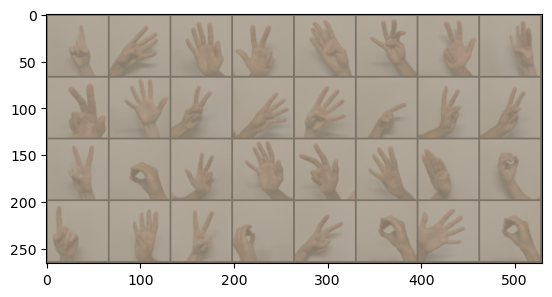

tensor([1, 4, 5, 3, 4, 4, 3, 4, 3, 5, 2, 4, 4, 1, 2, 2, 2, 0, 3, 5, 3, 4, 4, 0,
        1, 4, 2, 0, 2, 0, 5, 0])


In [12]:
for inputs, targets in dataloader:
    out = make_grid(inputs)
    imshow(out) # 32 images as the defined batch size
    print(targets)
    break
    

In [13]:
device = torch.device('cuda') #GPU
print(device)

cuda


In [14]:
net = Net(32).to(device)

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr = 1e-3, momentum=0.9)


In [15]:
class RunningMetric():
    def __init__(self) -> None:
        self.S = 0
        self.N = 0

    def update(self, val, size):
        self.S += val
        self.N += size
    
    def __call__(self):
        return self.S/float(self.N)

In [16]:
num_epochs = 100

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-'*20)

    running_loss = RunningMetric() # Loss
    running_acc = RunningMetric() # Accuracy
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device) # GPU
        optimizer.zero_grad() # Reset gradients to zero. In one loop (batch) the gradients were modified by the optimizer

        outputs = net(inputs) # outputs from the NN
        _, preds = torch.max(outputs, 1) # Get predictions
        loss = loss_fn(outputs, targets) # Calculate loss

        loss.backward() # Calculate gradients automatically
        optimizer.step() # Update of the parameters

        batch_size = inputs.size()[0] # get batch size
        running_loss.update(loss.item()*batch_size, batch_size) # calculate metric of loss
        running_acc.update(torch.sum(preds==targets).float(), batch_size) # calculate metric of accuraccy

    print("Loss: {:.4f}, Acc: {:.4f}".format(running_loss(), running_acc()))


Epoch 1/100
--------------------
Loss: 1.7931, Acc: 0.1690
Epoch 2/100
--------------------
Loss: 1.7924, Acc: 0.1736
Epoch 3/100
--------------------
Loss: 1.7918, Acc: 0.1898
Epoch 4/100
--------------------
Loss: 1.7913, Acc: 0.2176
Epoch 5/100
--------------------
Loss: 1.7908, Acc: 0.2616
Epoch 6/100
--------------------
Loss: 1.7904, Acc: 0.2326
Epoch 7/100
--------------------
Loss: 1.7899, Acc: 0.1829
Epoch 8/100
--------------------
Loss: 1.7895, Acc: 0.1736
Epoch 9/100
--------------------
Loss: 1.7891, Acc: 0.1701
Epoch 10/100
--------------------
Loss: 1.7887, Acc: 0.1725
Epoch 11/100
--------------------
Loss: 1.7882, Acc: 0.1759
Epoch 12/100
--------------------
Loss: 1.7878, Acc: 0.1898
Epoch 13/100
--------------------
Loss: 1.7873, Acc: 0.2060
Epoch 14/100
--------------------
Loss: 1.7868, Acc: 0.2512
Epoch 15/100
--------------------
Loss: 1.7862, Acc: 0.2627
Epoch 16/100
--------------------
Loss: 1.7857, Acc: 0.2396
Epoch 17/100
--------------------
Loss: 1.7850, A

## Autograd

In [17]:
x = torch.Tensor(2)
x.requires_grad = True
loss = 13*x[0] + 7*x[1] + 1
loss.backward()

print(x)
x.grad

tensor([7.3073e-12, 4.5553e-41], requires_grad=True)


tensor([13.,  7.])

In [18]:
x = torch.rand((2,3), requires_grad=True)
print(x)
y = torch.Tensor([[1, 2], [3, 4]])
print(y)
loss = y.mm(x)
print(loss)
loss = loss.sum()
print(loss)
loss.backward()
print(x.grad)

tensor([[0.3932, 0.2173, 0.7413],
        [0.8499, 0.0536, 0.8308]], requires_grad=True)
tensor([[1., 2.],
        [3., 4.]])
tensor([[2.0931, 0.3245, 2.4029],
        [4.5794, 0.8663, 5.5471]], grad_fn=<MmBackward>)
tensor(15.8132, grad_fn=<SumBackward0>)
tensor([[4., 4., 4.],
        [6., 6., 6.]])


In [19]:
train = True

with torch.set_grad_enabled(train):
    # computos con tensores
    pass

## Evaluate

In [20]:
trainset = SIGNSDataset('/home/shihao/ProjectDiego/tutorials/pyTorch/dl-pytorch/datasets/64x64_SIGNS', split="train", transform = transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size = 32)

In [21]:
valset = SIGNSDataset('/home/shihao/ProjectDiego/tutorials/pyTorch/dl-pytorch/datasets/64x64_SIGNS', split="val", transform = transforms.ToTensor())
valloader = DataLoader(valset, batch_size = 32)

In [22]:
testset = SIGNSDataset('/home/shihao/ProjectDiego/tutorials/pyTorch/dl-pytorch/datasets/64x64_SIGNS', split="test", transform = transforms.ToTensor())
testloader = DataLoader(testset, batch_size = 32)

In [23]:
dataloaders = {'train': trainloader,
               'val': valloader,
               'test': testloader}

In [24]:
# Data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [44]:
class Net2(nn.Module):
    def __init__(self, num_channels):
        super(Net2, self).__init__()

        self.num_channels = num_channels

        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.num_channels)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.num_channels*2)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.num_channels*4)

        self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
        self.fcbn1 = nn.BatchNorm1d(self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)

    def forward(self, x):
        # init shape: 3x64x64
        x = self.bn1(self.conv1(x))     # num_channelsx64x64
        x = F.relu(F.max_pool2d(x, 2))  # num_channelsx32x32
        x = self.bn2(self.conv2(x))     # num_channels*2x32x32
        x = F.relu(F.max_pool2d(x, 2))  # num_channels*2x16x16
        x = self.bn3(self.conv3(x))     # num_channels*4x16x16
        x = F.relu(F.max_pool2d(x, 2))  # num_channels*4x8x8

        # Flatten
        x = x.view(-1, self.num_channels*4*8*8)

        # FC 
        x = F.relu(self.fcbn1(self.fc1(x)))
        x = F.dropout(x, p=0.8, training=True)
        x = self.fc2(x)

        # Log_softmax
        x = F.log_softmax(x, dim=1)

        return x


## Training 2

In [45]:
def train_and_evaluate(model, optimizer, loss_fn, dataloaders, device, num_epochs=10, lr=0.001):

    for g in optimizer.param_groups:
        g['lr'] = lr

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = RunningMetric() # Loss
            running_acc = RunningMetric() # Accuracy
            
            for inputs, targets in dataloader:
                inputs, targets = inputs.to(device), targets.to(device) # GPU
                optimizer.zero_grad() # Reset gradients to zero. In one loop (batch) the gradients were modified by the optimizer

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # outputs from the NN
                    _, preds = torch.max(outputs, 1) # Get predictions
                    loss = loss_fn(outputs, targets) # Calculate loss
                    if phase=='train':
                        loss.backward() # Calculate gradients automatically
                        optimizer.step() # Update of the parameters

                batch_size = inputs.size()[0] # get batch size
                running_loss.update(loss.item()*batch_size, batch_size) # calculate metric of loss
                running_acc.update(torch.sum(preds==targets).float(), batch_size) # calculate metric of accuraccy

            print("Loss: {:.4f}, Acc: {:.4f}".format(running_loss(), running_acc()))

    return model

In [46]:
import random

lrs = [10**(-random.randint(3,7)) for _ in range(3)]
print(lrs)

[1e-07, 1e-07, 1e-05]


In [47]:
net2 = Net2(32).to(device)

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net2.parameters(), lr = 1e-3, momentum=0.9)

for lr in lrs:
    train_and_evaluate(net2, optimizer, loss_fn, dataloaders, device, 10, lr)

Epoch 1/10
--------------------
Loss: 2.1814, Acc: 0.1597
Loss: 2.0891, Acc: 0.1655
Epoch 2/10
--------------------
Loss: 2.1910, Acc: 0.1574
Loss: 2.1177, Acc: 0.1701
Epoch 3/10
--------------------
Loss: 2.1167, Acc: 0.1632
Loss: 2.2062, Acc: 0.1412
Epoch 4/10
--------------------
Loss: 2.1711, Acc: 0.1424
Loss: 2.1844, Acc: 0.1644
Epoch 5/10
--------------------
Loss: 2.1578, Acc: 0.1400
Loss: 2.1634, Acc: 0.1632
Epoch 6/10
--------------------
Loss: 2.1661, Acc: 0.1574
Loss: 2.1880, Acc: 0.1505
Epoch 7/10
--------------------
Loss: 2.1885, Acc: 0.1690
Loss: 2.2426, Acc: 0.1389
Epoch 8/10
--------------------
Loss: 2.1708, Acc: 0.1586
Loss: 2.1987, Acc: 0.1551
Epoch 9/10
--------------------
Loss: 2.1416, Acc: 0.1528
Loss: 2.1722, Acc: 0.1597
Epoch 10/10
--------------------
Loss: 2.2235, Acc: 0.1458
Loss: 2.1579, Acc: 0.1620
Epoch 1/10
--------------------
Loss: 2.2121, Acc: 0.1539
Loss: 2.1365, Acc: 0.1539
Epoch 2/10
--------------------
Loss: 2.1799, Acc: 0.1528
Loss: 2.1438, Acc